In [ ]:
# 트랜스포머 + 트랜스포머 앙상블
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 읽기
data_c30 = pd.read_csv('data_c30.csv')
lane_data_c = pd.read_csv('lane_data_c.csv')

# 데이터 병합
merged_data = pd.merge(data_c30, lane_data_c, on='Distance')

# 데이터 필터링
filtered_data = merged_data[(merged_data['Distance'] <= 2500)]

# 타겟 및 피처 정의
target_cols = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']
features_cols = [col for col in filtered_data.columns if col not in ['Distance'] + target_cols]

# 데이터 분할
train_data, test_data = train_test_split(filtered_data, test_size=0.25, shuffle=False)
X_train = train_data[features_cols].values
y_train = train_data[target_cols].values
X_test = test_data[features_cols].values
y_test = test_data[target_cols].values

# 시퀀스 생성 함수
def create_sequences(data, target, input_sequence_length, target_sequence_length):
    input_sequences = []
    target_sequences = []
    for i in range(len(data) - input_sequence_length - target_sequence_length + 1):
        input_sequences.append(data[i:i+input_sequence_length])
        target_sequences.append(target[i+input_sequence_length:i+input_sequence_length+target_sequence_length])
    return np.array(input_sequences), np.array(target_sequences)

input_sequence_length = 10
target_sequence_length = 1
X_train_seq, y_train_seq = create_sequences(X_train, y_train, input_sequence_length, target_sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, input_sequence_length, target_sequence_length)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer(src, src)
        return self.decoder(output)

d_model = 64
nhead = 8
num_encoder_layers = 3
input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]
model = TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터를 PyTorch 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 앙상블 모델의 수
num_models = 4

# 모델들을 저장할 리스트
models = [TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers) for _ in range(num_models)]

# 각 모델에 대한 옵티마이저와 손실 함수
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]
criterions = [nn.MSELoss() for _ in range(num_models)]

# 각 모델을 학습
for idx, (model, optimizer, criterion) in enumerate(zip(models, optimizers, criterions)):
    print(f"Training model {idx+1}/{num_models}")
    for epoch in range(3):
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# 각 모델로부터 예측값 얻기
all_predictions = []
for model in models:
    predictions = []
    last_known_data = filtered_data[-input_sequence_length:].copy()
    for _ in range((4499 - 2500) // target_sequence_length):
        input_seq = torch.tensor(last_known_data[features_cols].values[-input_sequence_length:], dtype=torch.float32).unsqueeze(0)
        predicted_seq = model(input_seq).detach().numpy()[0, -1, :]
        predictions.append(predicted_seq)
        new_row = pd.DataFrame([last_known_data.iloc[-1].copy()])
        new_row['Distance'] += target_sequence_length
        new_row[target_cols] = predicted_seq
        last_known_data = pd.concat([last_known_data, new_row], ignore_index=True)
    all_predictions.append(predictions)

# 모든 모델의 예측값을 평균내기
avg_predictions = np.mean(all_predictions, axis=0)

# 시각화
def plot_predictions(past_data, predicted, target_cols):
    fig, axes = plt.subplots(nrows=len(target_cols), ncols=1, figsize=(10, 15))
    for i, col in enumerate(target_cols):
        axes[i].plot(past_data['Distance'], past_data[col], label='Past Data', color='blue')
        start_point = int(past_data['Distance'].max()) + input_sequence_length
        end_point = start_point + len(predicted)
        predicted_distances = range(start_point, end_point)
        axes[i].plot(predicted_distances, predicted[:, i], label='Predicted', color='red')
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

#리스트를 넘파이어레이로 변환
predicted_data = np.array(predictions)

plot_predictions(filtered_data, predicted_data, target_cols)

# 'answer_sample.csv' 파일에 예측값 저장
answer_sample = pd.read_csv('answer_sample.csv')
answer_sample['YL_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 0]
answer_sample['YR_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 1]
answer_sample['YL_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 2]
answer_sample['YR_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 3]
answer_sample.to_csv('answer_sample.csv', index=False)

In [ ]:
# 다중분포예측 트랜스포머
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 읽기
data_c30 = pd.read_csv('data_c30.csv')
lane_data_c = pd.read_csv('lane_data_c.csv')

# 데이터 병합
merged_data = pd.merge(data_c30, lane_data_c, on='Distance')

# 데이터 필터링
filtered_data = merged_data[(merged_data['Distance'] <= 2500)]

# 타겟 및 피처 정의
target_cols = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']
features_cols = [col for col in filtered_data.columns if col not in ['Distance'] + target_cols]

# 데이터 분할
train_data, test_data = train_test_split(filtered_data, test_size=0.25, shuffle=False)
X_train = train_data[features_cols].values
y_train = train_data[target_cols].values
X_test = test_data[features_cols].values
y_test = test_data[target_cols].values

# 데이터 정규화
mean_X_train = X_train.mean(axis=0)
std_X_train = X_train.std(axis=0)
mean_y_train = y_train.mean(axis=0)
std_y_train = y_train.std(axis=0)

X_train_normalized = (X_train - mean_X_train) / std_X_train
y_train_normalized = (y_train - mean_y_train) / std_y_train
X_test_normalized = (X_test - mean_X_train) / std_X_train
y_test_normalized = (y_test - mean_y_train) / std_y_train

# 시퀀스 생성 함수
def create_sequences(data, target, input_sequence_length, target_sequence_length):
    input_sequences = []
    target_sequences = []
    for i in range(len(data) - input_sequence_length - target_sequence_length + 1):
        input_sequences.append(data[i:i+input_sequence_length])
        target_sequences.append(target[i+input_sequence_length:i+input_sequence_length+target_sequence_length])
    return np.array(input_sequences), np.array(target_sequences)

input_sequence_length = 10
target_sequence_length = 1
X_train_seq, y_train_seq = create_sequences(X_train, y_train, input_sequence_length, target_sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, input_sequence_length, target_sequence_length)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers)
        self.decoder_mean = nn.Linear(d_model, output_dim)
        self.decoder_std = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer(src, src)
        mean = self.decoder_mean(output)
        std = torch.exp(0.5 * self.decoder_std(output))  # Ensure standard deviation is positive
        return mean, std

# 가우시안 분포의 확률 밀도 함수를 계산하는 손실 함수
def gaussian_pdf_loss(output_mean, output_std, target):
    epsilon = 1e-6  # To prevent division by zero
    mse_loss = ((output_mean - target) ** 2) / (2 * (output_std ** 2) + epsilon)
    log_loss = torch.log(output_std + epsilon)
    return torch.mean(mse_loss + log_loss)

d_model = 64
nhead = 8
num_encoder_layers = 3
input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]
model = TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터를 PyTorch 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 학습 루프
for epoch in range(1):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output_mean, output_std = model(inputs)
        loss = gaussian_pdf_loss(output_mean, output_std, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item()}")

# 예측 루프
last_known_data = filtered_data[-input_sequence_length:]
predictions = []
for _ in range((4499 - 2500) // target_sequence_length):
    input_seq = torch.tensor(last_known_data[features_cols].values, dtype=torch.float32).unsqueeze(0)
    predicted_mean, _ = model(input_seq)
    predicted_seq = predicted_mean.detach().numpy()[0, -1, :]
    predictions.append(predicted_seq)

    new_row = pd.DataFrame([last_known_data.iloc[-1].copy()])
    new_row['Distance'] += target_sequence_length
    new_row[target_cols] = predicted_seq
    last_known_data = pd.concat([last_known_data, new_row], ignore_index=True)
    last_known_data = last_known_data.iloc[-input_sequence_length:]

# 예측 후 원래의 스케일로 변환
predicted_data = np.array(predictions) * std_y_train + mean_y_train

# 시각화
def plot_predictions(past_data, predicted, target_cols):
    fig, axes = plt.subplots(nrows=len(target_cols), ncols=1, figsize=(10, 15))
    for i, col in enumerate(target_cols):
        axes[i].plot(past_data['Distance'], past_data[col], label='Past Data', color='blue')
        start_point = int(past_data['Distance'].max()) + input_sequence_length
        end_point = start_point + len(predicted)
        predicted_distances = range(start_point, end_point)
        axes[i].plot(predicted_distances, predicted[:, i], label='Predicted', color='red')
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

#리스트를 넘파이어레이로 변환
predicted_data = np.array(predictions)

plot_predictions(filtered_data, predicted_data, target_cols)

# 'answer_sample.csv' 파일에 예측값 저장
answer_sample = pd.read_csv('answer_sample.csv')
answer_sample['YL_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 0]
answer_sample['YR_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 1]
answer_sample['YL_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 2]
answer_sample['YR_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 3]
answer_sample.to_csv('answer_sample.csv', index=False)


Epoch 1/10, Loss: -2.244006872177124
Epoch 2/10, Loss: -3.1081767082214355


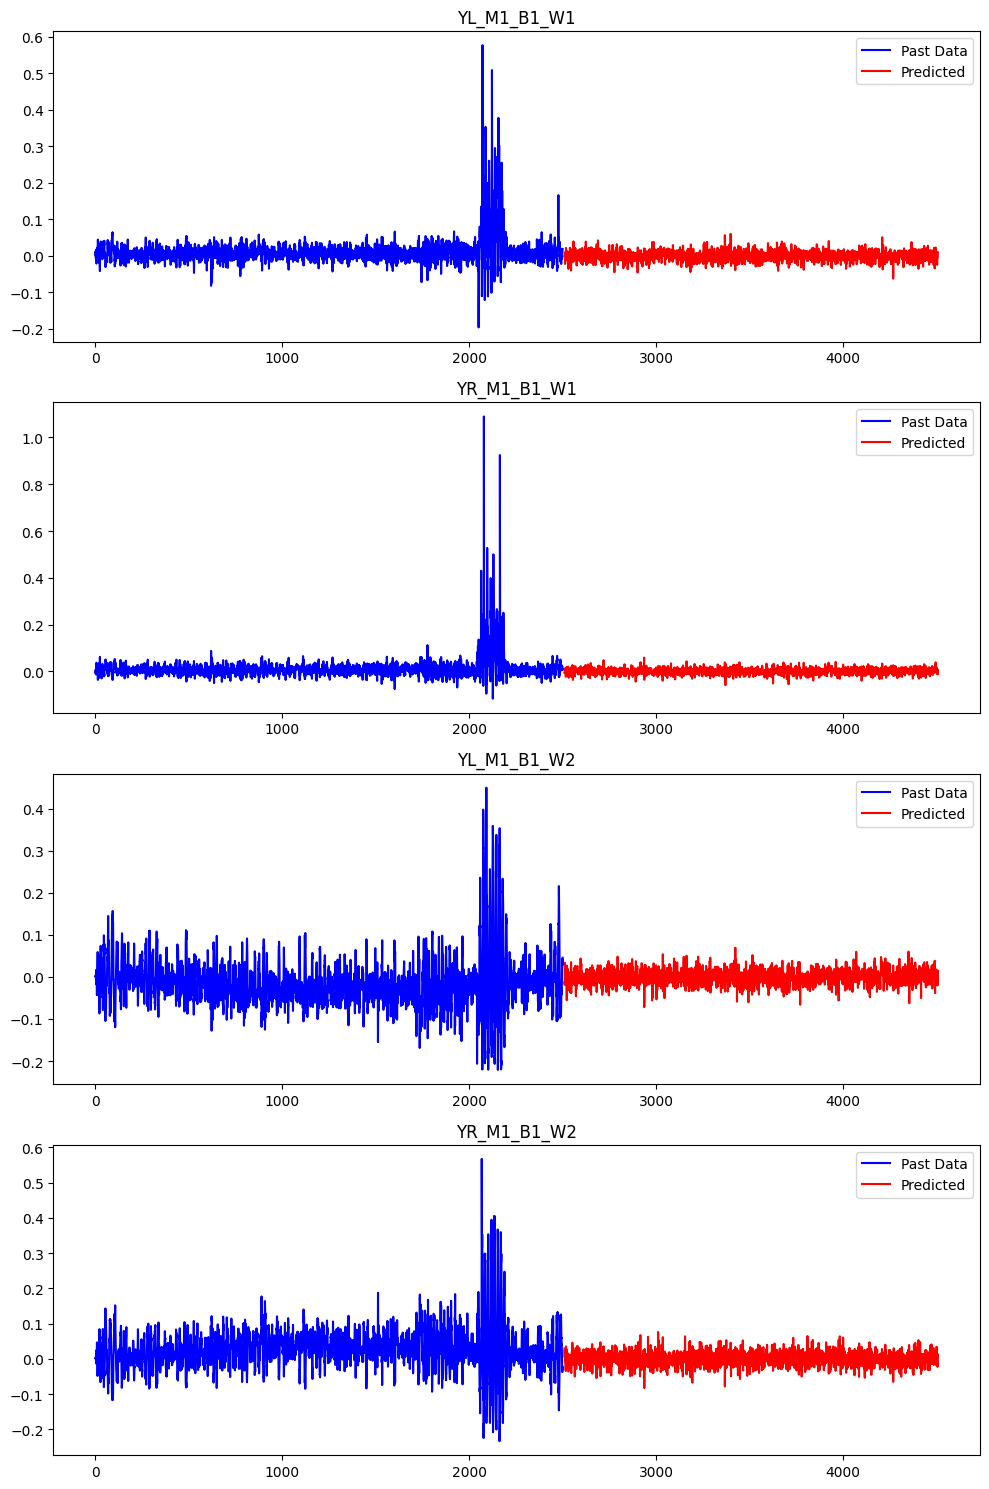

In [13]:
# 다중분포예측 + 강제평균0 트랜스포머
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 읽기
data_c30 = pd.read_csv('data_c30.csv')
lane_data_c = pd.read_csv('lane_data_c.csv')

# 데이터 병합
merged_data = pd.merge(data_c30, lane_data_c, on='Distance')

# 데이터 필터링
filtered_data = merged_data[(merged_data['Distance'] <= 2500)]

# 타겟 및 피처 정의
target_cols = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']
features_cols = [col for col in filtered_data.columns if col not in ['Distance'] + target_cols]

# 데이터 분할
train_data, test_data = train_test_split(filtered_data, test_size=0.25, shuffle=False)
X_train = train_data[features_cols].values
y_train = train_data[target_cols].values
X_test = test_data[features_cols].values
y_test = test_data[target_cols].values

# 데이터 정규화
mean_X_train = X_train.mean(axis=0)
std_X_train = X_train.std(axis=0)
mean_y_train = y_train.mean(axis=0)
std_y_train = y_train.std(axis=0)

X_train_normalized = (X_train - mean_X_train) / std_X_train
y_train_normalized = (y_train - mean_y_train) / std_y_train
X_test_normalized = (X_test - mean_X_train) / std_X_train
y_test_normalized = (y_test - mean_y_train) / std_y_train

# 시퀀스 생성 함수
def create_sequences(data, target, input_sequence_length, target_sequence_length):
    input_sequences = []
    target_sequences = []
    for i in range(len(data) - input_sequence_length - target_sequence_length + 1):
        input_sequences.append(data[i:i+input_sequence_length])
        target_sequences.append(target[i+input_sequence_length:i+input_sequence_length+target_sequence_length])
    return np.array(input_sequences), np.array(target_sequences)

input_sequence_length = 10
target_sequence_length = 1
X_train_seq, y_train_seq = create_sequences(X_train, y_train, input_sequence_length, target_sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, input_sequence_length, target_sequence_length)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers)
        self.decoder_mean = nn.Linear(d_model, output_dim)
        self.decoder_std = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer(src, src)
        mean = self.decoder_mean(output)
        std = torch.exp(0.5 * self.decoder_std(output))  # Ensure standard deviation is positive
        return mean, std

# 가우시안 분포의 확률 밀도 함수를 계산하는 손실 함수
def gaussian_pdf_loss(output_mean, output_std, target):
    epsilon = 1e-6  # To prevent division by zero
    mse_loss = ((output_mean - target) ** 2) / (2 * (output_std ** 2) + epsilon)
    log_loss = torch.log(output_std + epsilon)
    return torch.mean(mse_loss + log_loss)

d_model = 64
nhead = 8
num_encoder_layers = 3
input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]
model = TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터를 PyTorch 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 학습 루프
for epoch in range(2):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output_mean, output_std = model(inputs)
        loss = gaussian_pdf_loss(output_mean, output_std, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item()}")

# 예측 루프
last_known_data = filtered_data[-input_sequence_length:]
predictions = []
for _ in range((4499 - 2500) // target_sequence_length):
    input_seq = torch.tensor(last_known_data[features_cols].values, dtype=torch.float32).unsqueeze(0)
    predicted_mean, _ = model(input_seq)
    predicted_seq = predicted_mean.detach().numpy()[0, -1, :]
    predictions.append(predicted_seq)

    new_row = pd.DataFrame([last_known_data.iloc[-1].copy()])
    new_row['Distance'] += target_sequence_length
    new_row[target_cols] = predicted_seq
    last_known_data = pd.concat([last_known_data, new_row], ignore_index=True)
    last_known_data = last_known_data.iloc[-input_sequence_length:]

# 예측 후 원래의 스케일로 변환
predicted_data = np.array(predictions) * std_y_train + mean_y_train

# 시각화
def plot_predictions(past_data, predicted, target_cols):
    fig, axes = plt.subplots(nrows=len(target_cols), ncols=1, figsize=(10, 15))
    for i, col in enumerate(target_cols):
        axes[i].plot(past_data['Distance'], past_data[col], label='Past Data', color='blue')
        start_point = int(past_data['Distance'].max()) + input_sequence_length
        end_point = start_point + len(predicted)
        predicted_distances = range(start_point, end_point)
        axes[i].plot(predicted_distances, predicted[:, i], label='Predicted', color='red')
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

#리스트를 넘파이어레이로 변환
predicted_data = np.array(predictions)

# 'YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2' 각각의 예측 평균 계산
mean_YL_M1_B1_W1 = predicted_data[:, 0].mean()
mean_YR_M1_B1_W1 = predicted_data[:, 1].mean()
mean_YL_M1_B1_W2 = predicted_data[:, 2].mean()
mean_YR_M1_B1_W2 = predicted_data[:, 3].mean()

# 각 예측값에서 해당 평균을 빼줌
predicted_data[:, 0] -= mean_YL_M1_B1_W1
predicted_data[:, 1] -= mean_YR_M1_B1_W1
predicted_data[:, 2] -= mean_YL_M1_B1_W2
predicted_data[:, 3] -= mean_YR_M1_B1_W2

# 시각화
plot_predictions(filtered_data, predicted_data, target_cols)

# 'answer_sample.csv' 파일에 조정된 예측값 저장
answer_sample['YL_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:, 0]
answer_sample['YR_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:, 1]
answer_sample['YL_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:, 2]
answer_sample['YR_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:, 3]
answer_sample.to_csv('answer_sample.csv', index=False)


Epoch 1/10, Loss: 0.21668827533721924


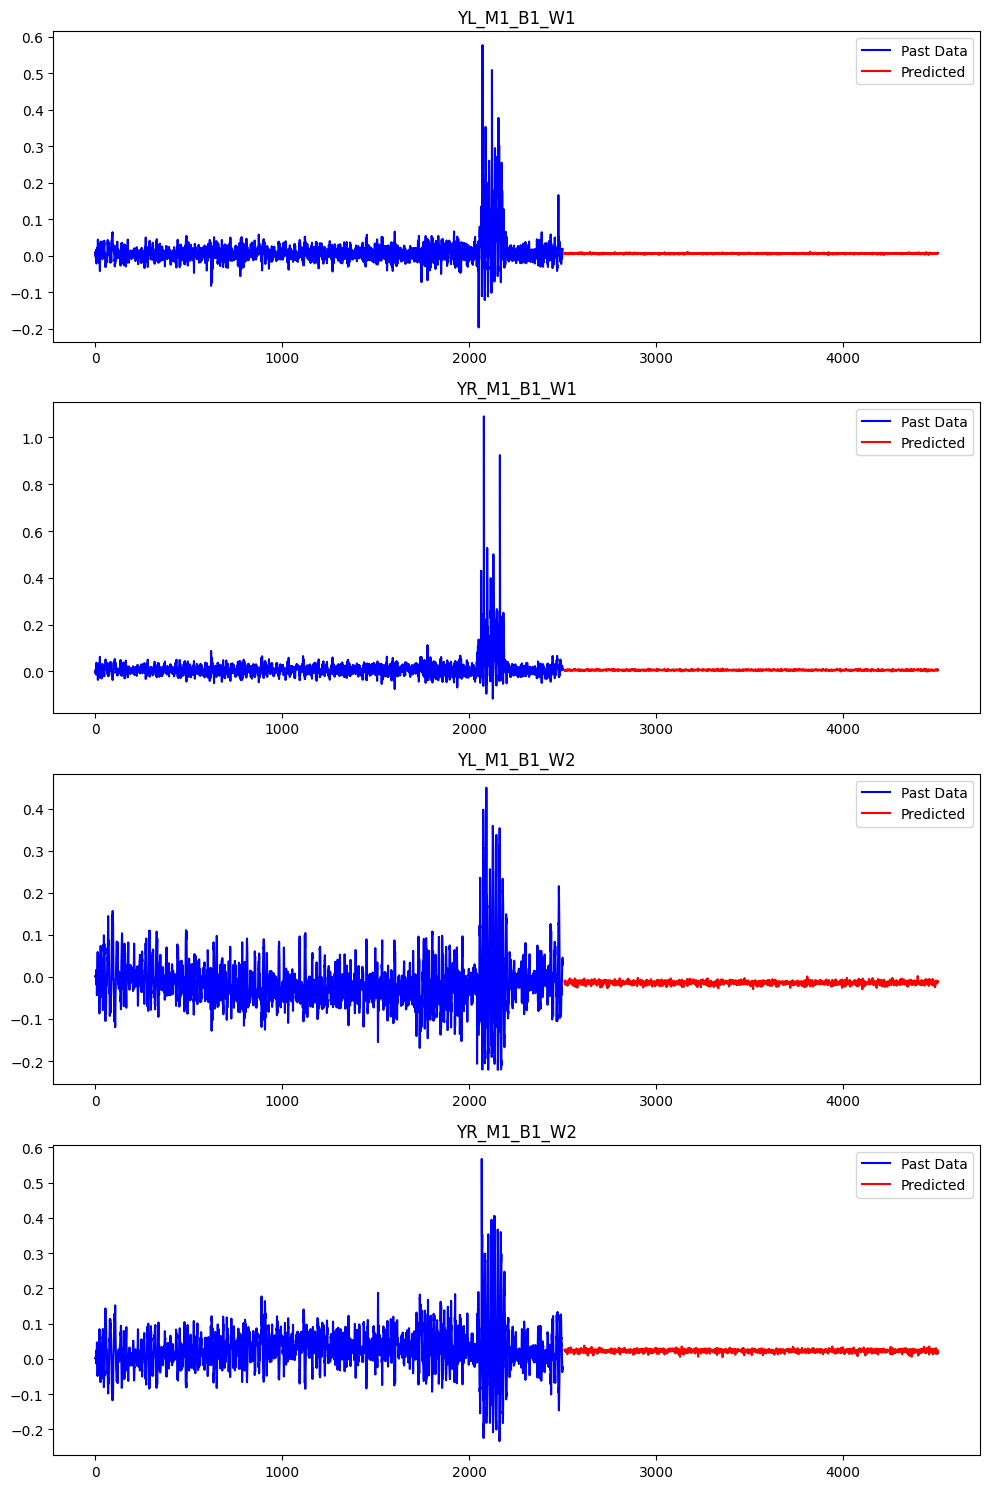

ValueError: cannot set using a slice indexer with a different length than the value

In [4]:
# 다중분포예측 + 정규화 + 강제평균0 트랜스포머
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 읽기
data_c30 = pd.read_csv('data_c30.csv')
lane_data_c = pd.read_csv('lane_data_c.csv')

# 데이터 병합
merged_data = pd.merge(data_c30, lane_data_c, on='Distance')

# 데이터 필터링
filtered_data = merged_data[(merged_data['Distance'] <= 2500)]

# 타겟 및 피처 정의
target_cols = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']
features_cols = [col for col in filtered_data.columns if col not in ['Distance'] + target_cols]

# 데이터 분할
train_data, test_data = train_test_split(filtered_data, test_size=0.25, shuffle=False)
X_train = train_data[features_cols].values
y_train = train_data[target_cols].values
X_test = test_data[features_cols].values
y_test = test_data[target_cols].values

# 데이터 정규화
mean_X_train = X_train.mean(axis=0)
std_X_train = X_train.std(axis=0)
mean_y_train = y_train.mean(axis=0)
std_y_train = y_train.std(axis=0)

X_train_normalized = (X_train - mean_X_train) / std_X_train
y_train_normalized = (y_train - mean_y_train) / std_y_train
X_test_normalized = (X_test - mean_X_train) / std_X_train
y_test_normalized = (y_test - mean_y_train) / std_y_train

# 시퀀스 생성 함수
def create_sequences(data, target, input_sequence_length, target_sequence_length):
    input_sequences = []
    target_sequences = []
    for i in range(len(data) - input_sequence_length - target_sequence_length + 1):
        input_sequences.append(data[i:i+input_sequence_length])
        target_sequences.append(target[i+input_sequence_length:i+input_sequence_length+target_sequence_length])
    return np.array(input_sequences), np.array(target_sequences)

input_sequence_length = 10
target_sequence_length = 1
X_train_seq, y_train_seq = create_sequences(X_train_normalized, y_train_normalized, input_sequence_length, target_sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_normalized, y_test_normalized, input_sequence_length, target_sequence_length)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers)
        self.decoder_mean = nn.Linear(d_model, output_dim)
        self.decoder_std = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.encoder(src)
        output = self.transformer(src, src)
        mean = self.decoder_mean(output)
        std = torch.exp(0.5 * self.decoder_std(output))  # Ensure standard deviation is positive
        return mean, std

# 가우시안 분포의 확률 밀도 함수를 계산하는 손실 함수
def gaussian_pdf_loss(output_mean, output_std, target):
    epsilon = 1e-6  # To prevent division by zero
    mse_loss = ((output_mean - target) ** 2) / (2 * (output_std ** 2) + epsilon)
    log_loss = torch.log(output_std + epsilon)
    return torch.mean(mse_loss + log_loss)

d_model = 64
nhead = 8
num_encoder_layers = 3
input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]
model = TransformerModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터를 PyTorch 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 학습 루프
for epoch in range(1):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output_mean, output_std = model(inputs)
        loss = gaussian_pdf_loss(output_mean, output_std, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item()}")

# 예측 루프
last_known_data = filtered_data[-input_sequence_length:]
predictions = []
for _ in range((4499 - 2500) // target_sequence_length):
    input_seq = torch.tensor(last_known_data[features_cols].values, dtype=torch.float32).unsqueeze(0)
    predicted_mean, _ = model(input_seq)
    predicted_seq = (predicted_mean.detach().numpy()[0, -1, :] * std_y_train) + mean_y_train
    predictions.append(predicted_seq)

    new_row = pd.DataFrame([last_known_data.iloc[-1].copy()])
    new_row['Distance'] += target_sequence_length
    new_row[target_cols] = predicted_seq
    last_known_data = pd.concat([last_known_data, new_row], ignore_index=True)
    last_known_data = last_known_data.iloc[-input_sequence_length:]

# 시각화
def plot_predictions(past_data, predicted, target_cols):
    fig, axes = plt.subplots(nrows=len(target_cols), ncols=1, figsize=(10, 15))
    for i, col in enumerate(target_cols):
        axes[i].plot(past_data['Distance'], past_data[col], label='Past Data', color='blue')
        start_point = int(past_data['Distance'].max()) + input_sequence_length
        end_point = start_point + len(predicted)
        predicted_distances = range(start_point, end_point)
        axes[i].plot(predicted_distances, predicted[:, i], label='Predicted', color='red')
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

predicted_data = np.array(predictions)
plot_predictions(filtered_data, predicted_data, target_cols)

# 'answer_sample.csv' 파일에 예측값 저장
answer_sample = pd.read_csv('answer_sample.csv')
answer_sample['YL_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 0]
answer_sample['YR_M1_B1_W1_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 1]
answer_sample['YL_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 2]
answer_sample['YR_M1_B1_W2_c30'].iloc[:len(predicted_data)] = predicted_data[:-1, 3]
answer_sample.to_csv('answer_sample.csv', index=False)
